<div align="center">
<font color="blue"><h1>GDAL - Manipulating Raster Data</h1>
<h3> Aug 10-14, 2020 @ UNAVCO</h3></font></div>

# Raster data manipulation with GDAL

In this tutorial, we will walk through examples of manipulating raster datasets with GDAL. We will focus on these common operations 

1. Format conversion
2. Cropping 
3. Oversampling/regridding
4. Multilooking

Note that we will not discuss coordinate transformation or projection conversion in this tutorial. We will discuss those topics in a separate tutorial.

## 0. Notebook setup

In [6]:
# Always run this cell at the start of each session
import os
import numpy as np
import matplotlib.pyplot as plt

from osgeo import gdal
gdal.UseExceptions()

if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    


#Utility function to load data
def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    #Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent

## 1. Download datasets

We will download the datasets used in this notebook. 

### Dataset 1: SRTM DEM tile in geotiff format over California from opentopography

In [2]:
!wget -nc https://cloud.sdsc.edu/v1/AUTH_opentopography/Raster/SRTM_GL1_Ellip/SRTM_GL1_Ellip_srtm/North/North_30_60/N33W119_wgs84.tif

File ‘N33W119_wgs84.tif’ already there; not retrieving.



### Dataset 2: Greenland DEM in netcdf format from Univ of Montana

In [3]:
!wget -nc http://websrv.cs.umt.edu/isis/images/a/ab/Greenland1km.nc

File ‘Greenland1km.nc’ already there; not retrieving.



### Dataset 3: Southern California DEM in GMT format from UC Santa Barbara

In [4]:
!wget -nc https://projects.eri.ucsb.edu/mapcat/mapftp/18.grd

File ‘18.grd’ already there; not retrieving.



### Dataset 4: USGS DEM over Bushkill, PA from PSU

In [5]:
!wget -nc https://courseware.e-education.psu.edu/downloads/natureofgeoinfo/DEM.zip

File ‘DEM.zip’ already there; not retrieving.



### Dataset 5: An example ISCE stripmapApp.py run folder

We can use any stripmapApp.py output folder. In our case, we will reuse the one from our earlier notebook using ALOS PALSAR data.

In [ ]:
#If you are on UNAVCO Jupyterlab setup, link to outputs from stripmap notebook
#If not feel free to use any stripmapApp.py run from ISCE
!ln -s /home/jovyan/work/Stripmap/Hawaii_ALOS1 stripmap

## 2. Utility: gdal_translate

We will be using the **gdal_translate** utility either as an executable or programatically for accomplishing all the above listed data manipulation operations in this tutorial. For list of options supported by **gdal_translate**, see  

http://www.gdal.org/gdal_translate.html

```bash
gdal_translate [--help-general]
       [-ot {Byte/Int16/UInt16/UInt32/Int32/Float32/Float64/
             CInt16/CInt32/CFloat32/CFloat64}] [-strict]
       [-of format] [-b band]* [-mask band] [-expand {gray|rgb|rgba}]
       [-outsize xsize[%]|0 ysize[%]|0] [-tr xres yres]
       [-r {nearest,bilinear,cubic,cubicspline,lanczos,average,mode}]
       [-unscale] [-scale[_bn] [src_min src_max [dst_min dst_max]]]* [-exponent[_bn] exp_val]*
       [-srcwin xoff yoff xsize ysize] [-epo] [-eco]
       [-projwin ulx uly lrx lry] [-projwin_srs srs_def]
       [-a_srs srs_def] [-a_ullr ulx uly lrx lry] [-a_nodata value]
       [-a_scale value] [-a_offset value]
       [-gcp pixel line easting northing [elevation]]*
       |-colorinterp{_bn} {red|green|blue|alpha|gray|undefined}]
       |-colorinterp {red|green|blue|alpha|gray|undefined},...]
       [-mo "META-TAG=VALUE"]* [-q] [-sds]
       [-co "NAME=VALUE"]* [-stats] [-norat]
       [-oo NAME=VALUE]*
       src_dataset dst_dataset
```

## 3. Format conversion

Converting raster data from one format to another is a common requirement to work with legacy code. If the software was built with GDAL support, this step would be optional. But we all have software written to work with flat binary files, single band geotiffs or GMT grd files. Here are some examples of using **gdal_translate** to convert formats.

### a. Converting single band images

In [7]:
#Convert DEM from GMT format to geotiff
!gdal_translate -of GTiff 18.grd SocalDEM_from_gmt.tif

Input file size is 1201, 601
0...10...20...30...40...50...60...70...80...90...100 - done.


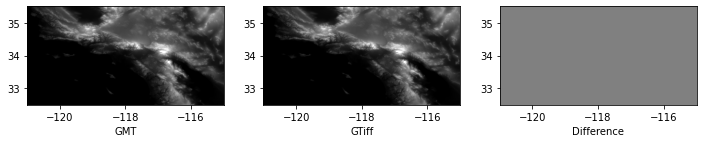

In [15]:
#Load and compare data from both formats
gmt, gmtext = loadData('18.grd')
tif, tifext = loadData('SocalDEM_from_gmt.tif')
plt.figure('GMT vs TIFF', figsize=(12,6))
ax1 = plt.subplot(1,3,1)
ax1.imshow(gmt, clim=[-7,2690], extent=gmtext, cmap='gray')
ax1.set_xlabel('GMT')
ax2 = plt.subplot(1,3,2)
ax2.imshow(tif, clim=[-7,2690], extent=tifext, cmap='gray')
ax2.set_xlabel('GTiff')
ax3 = plt.subplot(1,3,3)
ax3.imshow(gmt-tif, clim=[-20,20], extent=tifext, cmap='gray')
ax3.set_xlabel('Difference')
plt.show()
gmt = None
tif = None

<br>
<div class="alert alert-info">
<b>Note :</b>

gdalinfo on the converted file reported a **tif.aux.xml** file as well. This is because GDAL provides support for translating the basic raster information from one to another. Each format has its own custom method of storing metadata - which may not be compatible with other formats. In such cases, GDAL will create an aux.xml to dump the metadata into it. 

</div>

### b. Converting a single band and assigning NoDataValue

In [ ]:
#Extract coherence layer
!gdal_translate -of GTiff -b 2 -a_nodata 0 stripmap/interferogram/topophase.cor.geo.vrt stripmap/interferogram/coherence.geo.tif

In [ ]:
#Look at the output
!gdalinfo stripmap/interferogram/coherence.geo.tif

### c. Creation options - format specific features

Each data format has its own special features. For example, many formats include support for data compression to save disk space. When translating data to these formats, some of these options can be enabled by adding **-co** options. These options are specific to formats and can be discovered via their documentation pages. For example:

* GeoTiff: http://www.gdal.org/frmt_gtiff.html
* netCDF: http://www.gdal.org/frmt_netcdf.html

In [ ]:
#We will create a compressed 16-bit floating type file for coherence with compression
!gdal_translate -of GTiff -b 2 -a_nodata 0 stripmap/interferogram/topophase.cor.geo.vrt stripmap/interferogram/coherence_compressed.geo.tif -co "NBITS=16" -co "COMPRESS=DEFLATE" 

In [ ]:
#Look at the file sizes
!ls -ltr stripmap/interferogram/*.tif

In [ ]:
#Look at the output
!gdalinfo stripmap/interferogram/coherence_compressed.geo.tif

### d. Flat binary files

GDAL supports a fairly large number of raw binary data formats - ENVI, SRTM, ROI_PAC, ISCE etc. A lot of these drivers are user contributed and are built on top of basic raw data handling mechanisms in GDAL. ENVI is widely used in industry and is possibly the most tested of the raw data formats. If you absolutely need to use raw binary formats for your intermediate products - we recommend that you use the ENVI format.

Support for other raw formats especially ROI_PAC and ISCE are limited and can get out of sync with the software generating them.

## 4. Cropping

Data cropping is a very common operation. GDAL allows us to crop data using map coordinates as well line/pixel locations. It even allows map locations in a coordinate system other than the one used by the source raster.

<br>
<div class="alert alert-info">
<b>Note :</b>

You can use VRT files to save disk space. You dont have to create cropped raster images unless absolutely needed.

</div>

### a. Cropping using map coordinates

In [ ]:
#Cropping in same coordinate system as source raster
# ulx uly lrx lry
!gdal_translate -of VRT -b 2 -projwin -155.3 19.5 -155.2 19.3 stripmap/interferogram/topophase.cor.geo.vrt stripmap/coherence_crop.vrt

In [ ]:
#Compare original and cropped data
orig, origext = loadData('stripmap/interferogram/topophase.cor.geo.vrt', band=2)
crop, cropext = loadData('stripmap/coherence_crop.vrt')

plt.figure('Source vs Crop')
ax1 = plt.subplot(1,2,1)
ax1.imshow(orig, clim=[0., 1.], extent=origext, cmap='gray')
ax1.set_xlabel('Original')
ax2 = plt.subplot(1,2,2)
ax2.imshow(crop, clim=[0., 1.], extent=cropext, cmap='gray')
ax2.set_xlabel('Cropped')
plt.show()

orig = None
crop= None

### b. Cropping using map coordinates but different coordinate system

We will use a DEM of Greenland in Polar Stereographic projection (EPSG:3413) for this example. This is accomplished using the **-projwin_srs** argument to **gdal_translate**

In [16]:
#Look at the input data
!gdalinfo NETCDF:"Greenland1km.nc":topg

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Driver: netCDF/Network Common Data Format
Files: Greenland1km.nc
Size is 1501, 2801
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["unnamed",
        METHOD["Polar Stereographic (variant B)",
            ID["EPSG",9829]],
        PARAMETER["Latitude of standard parallel",71,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8832]],
        PARAMETER["Longitude of origin",-39,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8833]],
        PARAMETER["False easting",0,
            LENGTHUNIT["unknown",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["unknown",1],

In [17]:
#Crop DEM using lat/lon coordinates
# ulx uly rlx rly
!gdal_translate -of VRT -projwin -55 71 -50 69 \
          -projwin_srs EPSG:4326 \
          NETCDF:"Greenland1km.nc":topg Greenland_crop.vrt

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Input file size is 1501, 2801


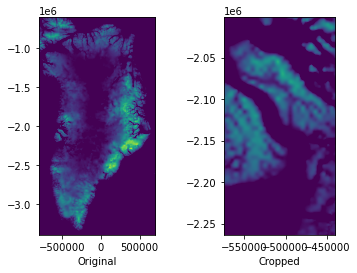

In [18]:
#Compare original and cropped data
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
crop, cropext = loadData('Greenland_crop.vrt')

plt.figure('Source vs Crop 2')
ax1 = plt.subplot(1,2,1)
ax1.imshow(orig, clim=[0., 3000.], extent=origext)
ax1.set_xlabel('Original')
ax2 = plt.subplot(1,2,2)
ax2.imshow(crop, clim=[0., 3000.], extent=cropext)
ax2.set_xlabel('Cropped')
plt.show()

orig = None
crop= None

### c. Cropping using line/pixel locations

One can also crop images using the line and pixel locations. This is particularly useful when working with rasters that are not geocoded. In our case, cropping radar geometry products can be accomplished using this approach. One should use the **-srcwin** argument to specify the region of interest.

In [19]:
#-srcwin xoff yoff xsize ysize
!gdal_translate -of VRT -srcwin 1500 1700 500 500 \
                N33W119_wgs84.tif SRTM_crop.vrt

Input file size is 3601, 3601


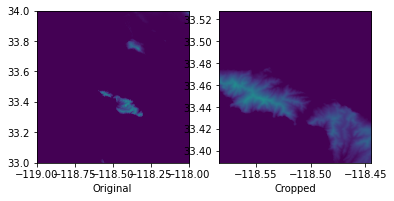

In [20]:
#Compare original and cropped data
orig, origext = loadData('N33W119_wgs84.tif')
crop, cropext = loadData('SRTM_crop.vrt')

plt.figure('Source vs Crop 3')
ax1 = plt.subplot(1,2,1)
ax1.imshow(orig, clim=[0., 1000.], extent=origext)
ax1.set_xlabel('Original')
ax2 = plt.subplot(1,2,2)
ax2.imshow(crop, clim=[0., 1000.], extent=cropext)
ax2.set_xlabel('Cropped')
plt.show()

orig = None
crop= None

Remember the raster layout from the tutorial on **Introduction to Raster Data**. **xoff, yoff** refers to the top-left corner of the first pixel of the region of interest. **xsize, ysize** refers to the number of pixels and lines in the region of interest.

## 5. Oversampling / regridding

Oversampling or regridding is another common data manipulation operations. We often need to regrid data from different sources to use them within the same tools. A typical example is the oversampling of the DEM. GDAL provides efficient support for certain types of interpolators to oversample of regrid the data. By default, the following interpolators are available

1. Nearest neighbor
2. Bilinear
3. Cubic
4. Cubic spline
5. Lanczos (Truncated sinc)
6. Average
7. Mode

The output format can again be VRT if needed. This is recommended if the oversampled / regridded data is an intermediate product and not going to used again and again. When VRT output format is used, resampling/regridding occurs on the fly when the dataset is read in.

### a. Regridding with sample spacing

One can directly provide sample spacing for regridding the data using the **-tr** argument.

In [21]:
#Oversample greenland dem to 2km
!gdal_translate -of GTiff -tr 2000 2000 -r cubicspline \
          NETCDF:"Greenland1km.nc":topg Greenland_2km.tif

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Input file size is 1501, 2801
0...10...20...30...40...50...60...70...80...90...100 - done.


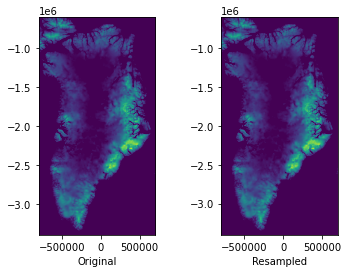

In [22]:
#Compare original and resampled data
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
grid, gridext = loadData('Greenland_2km.tif')

plt.figure('Greenland')
ax1 = plt.subplot(1,2,1)
ax1.imshow(orig, clim=[0., 3000.], extent=origext)
ax1.set_xlabel('Original')
ax2 = plt.subplot(1,2,2)
ax2.imshow(grid, clim=[0., 3000.], extent=gridext)
ax2.set_xlabel('Resampled')
plt.show()

orig = None
grid = None

### b. Regridding with output size

One can also directly specify the expected output size and **gdal_translate** will automatically compute the corresponding pixel spacing.

In [23]:
#Greenland DEM downsampled to 60, 110
!gdal_translate -of GTiff -outsize 60 110 -r nearest \
        NETCDF:"Greenland1km.nc":topg Greenland_subsample.tif

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Input file size is 1501, 2801
0...10...20...30...40...50...60...70...80...90...100 - done.


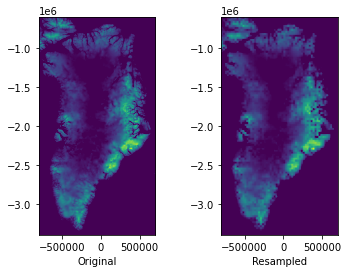

In [24]:
#Compare original and resampled data
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
grid, gridext = loadData('Greenland_subsample.tif')

plt.figure('Greenland 2')
ax1 = plt.subplot(1,2,1)
ax1.imshow(orig, clim=[0., 3000.], extent=origext)
ax1.set_xlabel('Original')
ax2 = plt.subplot(1,2,2)
ax2.imshow(grid, clim=[0., 3000.], extent=gridext)
ax2.set_xlabel('Resampled')
plt.show()

orig = None
grid = None

### c. Regridding with relative size

Alternately, **-outsize** can also accept relative size in percentages. 

In [25]:
!gdal_translate -of GTiff -outsize 10% 10% \
        NETCDF:"Greenland1km.nc":topg Greenland_10perc.tif

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Input file size is 1501, 2801
0...10...20...30...40...50...60...70...80...90...100 - done.


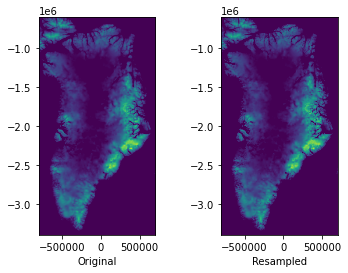

In [26]:
#Compare original and resampled data
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
grid, gridext = loadData('Greenland_10perc.tif')

plt.figure('Greenland 3')
ax1 = plt.subplot(1,2,1)
ax1.imshow(orig, clim=[0., 3000.], extent=origext)
ax1.set_xlabel('Original')
ax2 = plt.subplot(1,2,2)
ax2.imshow(grid, clim=[0., 3000.], extent=gridext)
ax2.set_xlabel('Resampled')
plt.show()

orig = None
grid = None

## 6. Multilooking

Multilooking is a very common operation in SAR / InSAR processing. In most common cases, data is reduced using a simple box car filter. This can be easily accomplished by manipulating the **-outsize** and **-srcwin** parameters. Here, we will set up a simple python function to multilook the data using GDAL.

In [27]:
def multiLook(infile, outfile, fmt='GTiff', xlooks=None, ylooks=None, noData=None, method='average'):
    '''
    infile - Input file to multilook
    outfile - Output file to multilook
    fmt - Output format
    xlooks - Number of looks in x/range direction
    ylooks - Number of looks in y/azimuth direction
    '''
    ds = gdal.Open(infile, gdal.GA_ReadOnly)

    #Input file dimensions
    xSize = ds.RasterXSize
    ySize = ds.RasterYSize

    #Output file dimensions
    outXSize = xSize//xlooks
    outYSize = ySize//ylooks

    ##Set up options for translation
    gdalTranslateOpts = gdal.TranslateOptions(format=fmt, 
                                              width=outXSize, height=outYSize,
                                             srcWin=[0,0,outXSize*xlooks, outYSize*ylooks],
                                             noData=noData, resampleAlg=method)

    #Call gdal_translate
    gdal.Translate(outfile, ds, options=gdalTranslateOpts)       
    ds = None

We will try using this function on some real valued and complex valued datasets.

### a. Real-valued example

In [ ]:
#Multilook the coherence file and then visualize the output
multiLook('stripmap/interferogram/topophase.cor.vrt', 'stripmap/coherence_3x.tif', 
          xlooks=3, ylooks=3, noData='0')

orig, origext = loadData('stripmap/interferogram/topophase.cor.vrt', band=2)
grid, gridext = loadData('stripmap/coherence_3x.tif', band=2)

plt.figure('Multilook 2')
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0, 1], extent=origext, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grid, clim=[0, 1], extent=gridext, cmap='gray')
plt.show()

print(orig.shape, grid.shape)
orig = None
grid = None

### b. Complex-valued example

In [ ]:
#Multilook the coherence file and then visualize the output
multiLook('stripmap/interferogram/topophase.flat.vrt', 'stripmap/flattened_3x.tif', 
          xlooks=3, ylooks=3, noData='0')

orig, origext = loadData('stripmap/interferogram/topophase.flat.vrt')
grid, gridext = loadData('stripmap/flattened_3x.tif')

plt.figure('Multilook 2')
plt.subplot(1,2,1)
plt.imshow(np.angle(orig), clim=[-np.pi, np.pi], extent=origext, cmap='hsv')
plt.subplot(1,2,2)
plt.imshow(np.angle(grid), clim=[-np.pi,np.pi ], extent=gridext, cmap='hsv')
plt.show()

print(orig.shape, grid.shape)
orig = None
grid = None

## Other features to keep an eye on

1. **gdaldem** is an utility that allows one to apply color palettes to raster images. Very fast and can use custom color palettes. Compatible with GMT's cpt files. (http://www.gdal.org/gdaldem.html)

2. **gdal_rasterize** allows users to rasterize shapefiles / vector formats. (http://www.gdal.org/gdal_rasterize.html)

3. **gdal_edit.py** allows users to edit raster metadata on the command line. (http://www.gdal.org/gdal_edit.html)